# Mount google drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import modules

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, RandomResizedCrop, RandomHorizontalFlip


# Dataset implement: animals dataset

In [13]:
class AnimalDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        super().__init__()
        self.image_paths = []
        self.labels = []
        self.categories = ["butterfly", "cat", "chicken", "cow", "dog",
                           "elephant", "horse", "sheep", "spider", "squirrel"]
        self.transform = transform

        if train:
            data_path = os.path.join(root, 'train')
        else:
            data_path = os.path.join(root, 'test')

        for i, category in enumerate(self.categories):
            data_files = os.path.join(data_path,category)
            for item in os.listdir(data_files):
                path = os.path.join(data_files,item)
                self.image_paths.append(path)
                self.labels.append(i)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Model implement: VGG16 architecture

In [14]:
class VVG16_net(nn.Module):
    def __init__(self, in_channels=3, n_classes=10):
        super().__init__()
        self.in_channels = in_channels
        self.conv1 = self.conv_block(in_channels=self.in_channels, block=[64, 64])
        self.conv2 = self.conv_block(in_channels=64, block=[128, 128])
        self.conv3 = self.conv_block(in_channels=128, block=[256, 256, 256])
        self.conv4 = self.conv_block(in_channels=256, block=[512, 512, 512])
        self.conv5 = self.conv_block(in_channels=512, block=[512, 512, 512])
        self.fcs = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, n_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.fcs(x)
        return x

    def conv_block(self, in_channels ,block):
        layers = []
        for i in block:
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=i, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                       nn.BatchNorm2d(i),
                       nn.ReLU()]
            in_channels = i
        layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
        return nn.Sequential(*layers)

# Training

## Set up hyperparameters

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
root = './drive/MyDrive/datasets/c_animals'
epochs = 40
batch_size = 32
num_workers = 2
logging = './drive/MyDrive/datasets/c_animals/logging'

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
size = 224

train_transform = Compose([
                ToPILImage(),
                RandomResizedCrop(224, scale=(0.5,1.0)),
                RandomHorizontalFlip(),
                ToTensor(),
                Normalize(mean, std)
            ])
test_transform = Compose([
                ToPILImage(),
                Resize((224, 224)),
                ToTensor(),
                Normalize(mean, std)
            ])

## Create dataset and dataloader

In [16]:
train_dataset = AnimalDataset(root= root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = AnimalDataset(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

23709
2596


## Define model

In [9]:
model = VVG16_net().to(device)
if os.path.exists('/content/drive/MyDrive/datasets/c_animals/model/last.pt'):
  if torch.cuda.is_available():
    model.load_state_dict(torch.load('/content/drive/MyDrive/datasets/c_animals/model/last.pt'))
  else:
    model.load_state_dict(torch.load('/content/drive/MyDrive/datasets/c_animals/model/last.pt', map_location=torch.device('cpu')))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9) #optim.Adam(model.parameters(), lr=1e-3)
best_acc = 0.8871
# writer = SummaryWriter(logging)

## Train model

In [ ]:
for epoch in range(epochs):
    model.train()
    progress_bar = tqdm(train_dataloader)
    for iter, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        # writer.add_scalar('Train/Loss', loss, epoch*len(train_dataloader)+iter)
        progress_bar.set_description('Epoch: {}/{} Iter: {} Loss: {:.4f}'.format(epoch+1, epochs, iter+1, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    all_predictions = []
    all_labels = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu())
    all_labels = [label.item() for label in all_labels]
    all_predictions = [prediction.item() for prediction in all_predictions]
    acc = accuracy_score(all_labels, all_predictions)
    print('Epoch: {}/{} Test Loss: {:.4f} Test Acc: {:.4f}'.format(epoch+1, epochs, loss.item(), acc))
    torch.save(model.state_dict(), './drive/MyDrive/datasets/c_animals/model/last.pt')
    if acc > best_acc:
        torch.save(model.state_dict(), './drive/MyDrive/datasets/c_animals/model/best.pt')
        best_acc=acc
    # writer.add_scalars('Val/Accuracy', acc, epoch)

Epoch: 1/40 Iter: 741 Loss: 0.4619: 100%|██████████| 741/741 [06:16<00:00,  1.97it/s]


Epoch: 1/40 Test Loss: 0.0018 Test Acc: 0.7824


Epoch: 2/40 Iter: 741 Loss: 0.3532: 100%|██████████| 741/741 [06:17<00:00,  1.96it/s]


Epoch: 2/40 Test Loss: 0.0068 Test Acc: 0.8413


Epoch: 3/40 Iter: 741 Loss: 0.3252: 100%|██████████| 741/741 [06:18<00:00,  1.96it/s]


Epoch: 3/40 Test Loss: 0.0548 Test Acc: 0.8259


Epoch: 4/40 Iter: 741 Loss: 0.5726: 100%|██████████| 741/741 [06:17<00:00,  1.96it/s]


Epoch: 4/40 Test Loss: 0.0279 Test Acc: 0.8363


Epoch: 5/40 Iter: 741 Loss: 0.5640: 100%|██████████| 741/741 [06:18<00:00,  1.96it/s]


Epoch: 5/40 Test Loss: 0.0330 Test Acc: 0.8367


Epoch: 6/40 Iter: 741 Loss: 0.1709: 100%|██████████| 741/741 [06:17<00:00,  1.96it/s]


Epoch: 6/40 Test Loss: 0.0015 Test Acc: 0.8602


Epoch: 7/40 Iter: 741 Loss: 0.2190: 100%|██████████| 741/741 [06:17<00:00,  1.96it/s]


Epoch: 7/40 Test Loss: 0.1084 Test Acc: 0.8594


Epoch: 8/40 Iter: 741 Loss: 0.2018: 100%|██████████| 741/741 [06:17<00:00,  1.96it/s]


Epoch: 8/40 Test Loss: 0.0027 Test Acc: 0.8690


Epoch: 9/40 Iter: 741 Loss: 0.0965: 100%|██████████| 741/741 [06:18<00:00,  1.96it/s]


Epoch: 9/40 Test Loss: 0.0065 Test Acc: 0.8594


Epoch: 10/40 Iter: 741 Loss: 0.3404: 100%|██████████| 741/741 [06:17<00:00,  1.96it/s]


Epoch: 10/40 Test Loss: 0.0017 Test Acc: 0.8794


Epoch: 11/40 Iter: 741 Loss: 0.4321: 100%|██████████| 741/741 [06:17<00:00,  1.96it/s]


Epoch: 11/40 Test Loss: 0.0016 Test Acc: 0.8621


Epoch: 12/40 Iter: 741 Loss: 0.0143: 100%|██████████| 741/741 [06:17<00:00,  1.96it/s]


Epoch: 12/40 Test Loss: 0.0068 Test Acc: 0.8274


Epoch: 13/40 Iter: 741 Loss: 0.1074: 100%|██████████| 741/741 [06:17<00:00,  1.96it/s]


Epoch: 13/40 Test Loss: 0.0013 Test Acc: 0.8871


Epoch: 14/40 Iter: 741 Loss: 0.1913: 100%|██████████| 741/741 [06:17<00:00,  1.96it/s]


Epoch: 14/40 Test Loss: 0.0043 Test Acc: 0.8833


Epoch: 15/40 Iter: 741 Loss: 0.2396: 100%|██████████| 741/741 [06:17<00:00,  1.96it/s]


# Examples

In [17]:
test_model = VVG16_net().to(device)
test_model.load_state_dict(torch.load('/content/drive/MyDrive/datasets/c_animals/model/best.pt', map_location=torch.device('cpu')))
test_model.eval()
# all_predictions_test = []
# all_labels_test = []
# for iter, (images, labels) in enumerate(test_dataloader):
#     images = images.to(device)
#     labels = labels.to(device)

#     with torch.no_grad():
#         outputs = test_model(images)
#         loss = criterion(outputs, labels)
#         predictions = torch.argmax(outputs.cpu(), dim=1)
#         all_predictions_test.extend(predictions)
#         all_labels_test.extend(labels.cpu())
# all_labels_test = [label.item() for label in all_labels_test]
# all_predictions_test = [prediction.item() for prediction in all_predictions_test]
# acc_test = accuracy_score(all_labels_test, all_predictions_test)
# print('Epoch: {}/{} Test Loss: {:.4f} Test Acc: {:.4f}'.format(epoch+1, epochs, loss.item(), acc_test))


VVG16_net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(


In [51]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
categories = ["butterfly", "cat", "chicken", "cow", "dog",
              "elephant", "horse", "sheep", "spider", "squirrel"]
indices = random.sample(range(0, test_dataset.__len__()), 8)
print(indices)
images = torch.stack([test_dataset.__getitem__(i)[0] for i in indices])
# images = torch.from_numpy(images)
# print(images)
# # labels = [categories[int(test_dataset.__getitem__(i)[1])] for i in indices]
labels = [test_dataset.__getitem__(i)[1] for i in indices]
predictions = torch.argmax(test_model(images).cpu(), dim=1)
print(images.shape)
print(labels)
print(predictions)

[1523, 1495, 1962, 2421, 288, 1204, 1462, 389]
torch.Size([8, 3, 224, 224])
[6, 6, 8, 9, 1, 4, 5, 2]
tensor([6, 4, 8, 9, 1, 4, 5, 2])


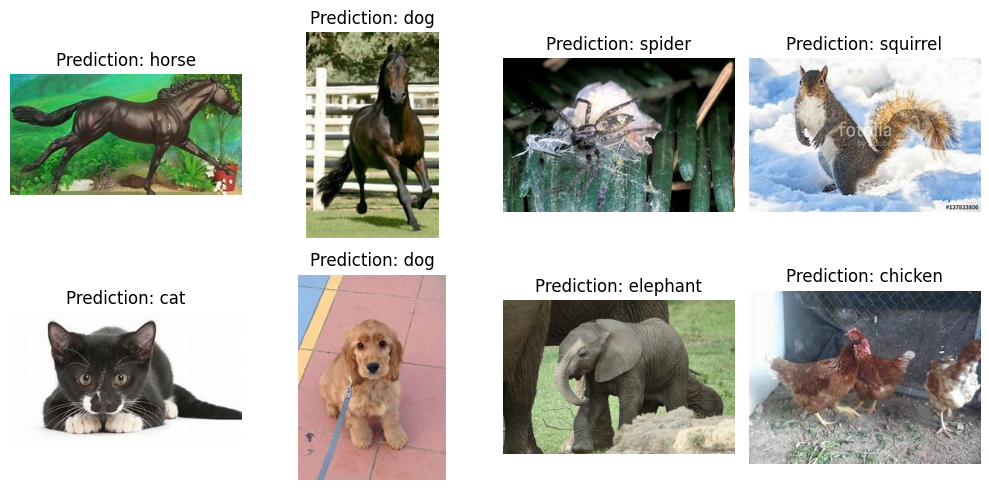

In [52]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for i in range(8):
  img = cv2.imread(test_dataset.image_paths[indices[i]])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axes[i].imshow(img)
  title = f"Prediction: {categories[predictions[i]]}"

  # if labels is not None:
  #     title += f"\nTrue Label: {categories[labels[i]]}"

  axes[i].set_title(title)
  axes[i].axis('off')

plt.tight_layout()
plt.show()